In [1]:
from settings import *
import numpy as np
from keras.utils import to_categorical
import utils as ut
import warnings
from Bio import Phylo
from Bio.Phylo.BaseTree import Tree
from matplotlib import pyplot as plt
import TreeClass
from TreeClass import Phylogenetic_Tree
import copy
import random

seed = 3
np.random.seed(seed)
random.seed(seed)

c:\Users\leonm\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\__init__.py:138: BiopythonWarning: You may be importing Biopython from inside the source tree. This is bad practice and might lead to downstream issues. In particular, you might encounter ImportErrors due to missing compiled C extensions. We recommend that you try running your code from outside the source tree. If you are outside the source tree then you have a setup.py file in an unexpected directory: c:\Users\leonm\AppData\Local\Programs\Python\Python310\lib\site-packages
  warnings.warn(


Phylogenetic_Tree(n_taxa=3, rooted=True, seq_len=10)
    Clade(name='Root', sequence='GTCTGGCGTC')
        Clade(branch_length=0.08002823868824799, mutations=2, name='V', sequence='GGCTGGCATC')
            Clade(branch_length=0.12315078467403451, mutations=2, name='S1', sequence='CTCTGGCATC')
            Clade(branch_length=0.12315078467403451, mutations=0, name='S2', sequence='GGCTGGCATC')
        Clade(branch_length=0.2031790233622825, mutations=0, name='S3', sequence='GTCTGGCGTC')


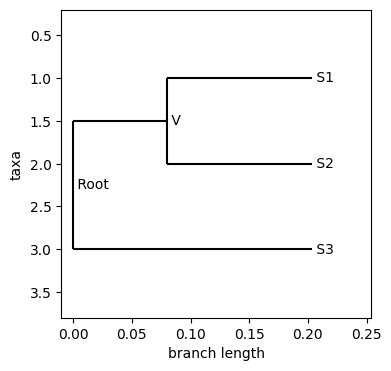

Likelihood: 1.3809505274513378e-12


In [2]:
# TESTING

# Generate a tree from file.

seq_len = 10

tree_basic = Phylogenetic_Tree().read_from_file("Trees/tree_basic.dnd", "newick")
tree_basic.generate_random_branch_lengths(distribution="exponential", type="ultrametric")
tree_basic.generate_sequences(seq_len)
print(tree_basic)

tree_basic.draw()
print(f"Likelihood: {tree_basic.calculate_likelihood()}")

Phylogenetic_Tree(n_taxa=10, rooted=True, seq_len=10)
    Clade(name='Root', sequence='TAATTACAAA')
        Clade(branch_length=0.06062762852276374, mutations=0, name='n0', sequence='TAATTACAAA')
            Clade(branch_length=0.022992945431838205, mutations=0, name='n00', sequence='TAATTACAAA')
                Clade(branch_length=0.3985756462753772, mutations=2, name='S2', sequence='CAATTACAAG')
                Clade(branch_length=0.07216187972258868, mutations=1, name='n001', sequence='TAATTACAAC')
                    Clade(branch_length=0.32641376655278853, mutations=4, name='S0', sequence='TCACTCCACC')
                    Clade(branch_length=0.06608456040418885, mutations=0, name='n0011', sequence='TAATTACAAC')
                        Clade(branch_length=0.26032920614859967, mutations=3, name='S6', sequence='TACTTACAGT')
                        Clade(branch_length=0.12299288392351478, mutations=0, name='n00111', sequence='TAATTACAAC')
                            Clade(branch_lengt

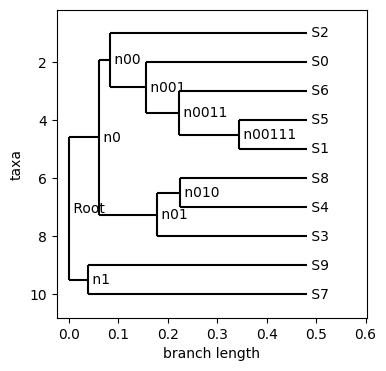

Likelihood: 1.1611292504436368e-45


1

In [3]:
# Generate a random tree and write to file

seq_len = 10
n_taxa = 10

tree_random = Phylogenetic_Tree().generate_random_topology(n_taxa=n_taxa)
tree_random.generate_random_branch_lengths(distribution="exponential", type="ultrametric")
tree_random.generate_sequences(seq_len)
print(tree_random)
tree_random.draw()
print(f"Likelihood: {tree_random.calculate_likelihood()}")

Phylo.write(tree_random, "Trees/tree_random.nex", "nexus")

### Explore tree space and evaluate posterior for tree

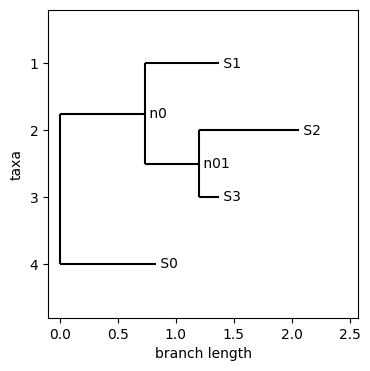

In [4]:
# Generate artificial data
# How should the branch lengths be generated? Uniform, exponential or other? TODO
# Probably, in the artificial data, it doesn't really matter. But it matters more in the prior and proposal distribution for the branch lengths 

def simulate_artificial_data(n_taxa, seq_len, outgroup):
    true_tree = Phylogenetic_Tree().generate_random_topology(n_taxa=n_taxa)
    true_tree.custom_root_with_outgroup(outgroup)
    true_tree.generate_random_branch_lengths(distribution="uniform")
    true_tree.generate_sequences(seq_len)
    data = {clade.name:clade.sequence for clade in true_tree.get_terminals()}
    return true_tree, data

seq_len = 100
n_taxa = 4
outgroup = "S0" # Outgroup fixed

true_tree, data = simulate_artificial_data(n_taxa, seq_len, outgroup)
taxa_names = list(data.keys())
taxa_sequences = list(data.values())

# Draw true tree
true_tree.draw()

# Calculate posterior for each tree (include prior information in posterior computation): TODO

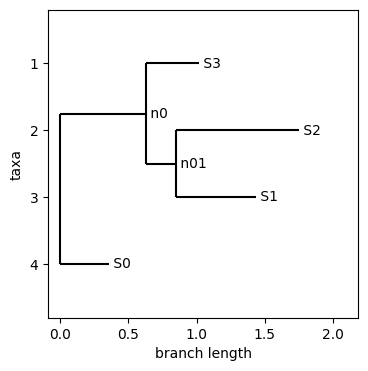

In [5]:
# Initialize random tree from sequence data

def initialize_random_tree(taxa_names, taxa_sequences, outgroup):
    tree_init = Phylogenetic_Tree().generate_random_topology(taxa_names=taxa_names) # Topology initialization
    tree_init.custom_root_with_outgroup(outgroup) # root with specified outgroup
    tree_init.generate_random_branch_lengths(distribution="uniform") # Branch lengths initialization
    
    # Clamp sequences to leaves
    for i, clade in enumerate(tree_init.get_terminals()):
        clade.sequence = taxa_sequences[i]

    return tree_init

# Initial tree (and every NNI tree) has to be rooted with specified outgroup: if outgroup is fixed, there is no possibility that the NNI eligible node has root as a parent, therefore basically we simplify the whole process
# When calculating the likelihood, does the ougroup become important? TODO

tree_init = initialize_random_tree(taxa_names, taxa_sequences, outgroup)
tree_init.draw()

True tree:


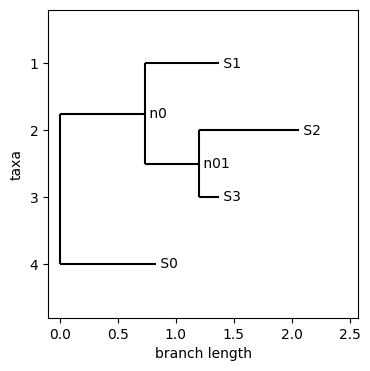

Initial proposal:


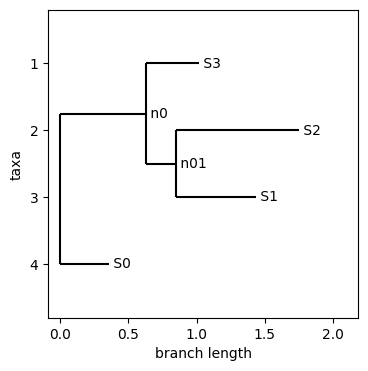

C:\Users\leonm\AppData\Local\Temp\ipykernel_19276\3318241674.py:61: RuntimeWarning: divide by zero encountered in scalar divide
  rho = np.min([1, NNI_tree.likelihood / tree_init.likelihood])
C:\Users\leonm\AppData\Local\Temp\ipykernel_19276\3318241674.py:61: RuntimeWarning: invalid value encountered in scalar divide
  rho = np.min([1, NNI_tree.likelihood / tree_init.likelihood])


Final tree:


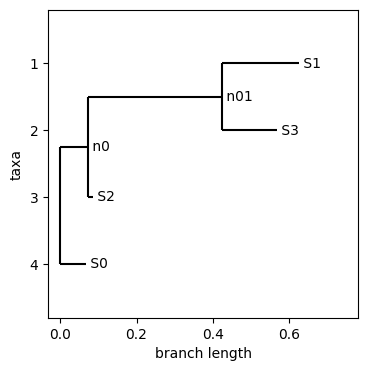

In [6]:
def NNI_permutable_nodes(tree, chosen_node): # 3 nodes that can be permuted in a rooted tree NNI step
    permutable = []
    permutable += chosen_node.clades # 2 children
    sibling = tree.get_sibling(chosen_node)
    if tree.parents[chosen_node] == tree.root: # if parent is root, get one nibling
        niblings = sibling.clades
        permutable.append(niblings[0])
    else: # if parent is not root, get sibling
        permutable.append(sibling)
    assert len(permutable) == 3 
    return permutable

def NNI_generate_topology(tree, chosen_node, permutable):
    NNI_tree = copy.deepcopy(tree)
    for NNI_clade in NNI_tree.get_nonterminals():
        if NNI_clade.name == chosen_node.name:
            NNI_clade.clades = permutable[:2]
            NNI_parent = NNI_tree.parents[NNI_clade]
            if NNI_parent == NNI_tree.root: # if parent is root, get the other nibling (the one that wasn't placed in permutable)
                NNI_sibling = NNI_tree.get_sibling(NNI_clade)
                NNI_niblings = NNI_sibling.clades
                NNI_sibling.clades = [permutable[2], NNI_niblings[1]]
            else: # if parent is not root
                NNI_parent.clades = [NNI_clade, permutable[2]]
    NNI_tree.parents = NNI_tree.dict_parents() # Update parents dictionary (only structure whose elements have undergone transformation when copying tree)
    return NNI_tree

# # NNI step:
# choose a node (from the eligible nodes)
# create new topology by performing NNI
# propose branch lengths
# compute likelihood

# Integrate in a single function NNI_permutable_nodes and NNI_generate_tree: NOT EASILY DONE, KEEP AS IS 


def NNI_step(tree_init):
    NNI_nodes = tree_init.NNI_eligible_nodes()
    # print(f"Internal edges: {[node.name for node in NNI_nodes]}")

    chosen_node = random.choice(NNI_nodes)
    # print(f"Chosen node: {chosen_node}")

    permutable = NNI_permutable_nodes(tree_init, chosen_node)
    # print(f"Nodes to be permuted: {[node.name for node in permutable]}")
    
    tree_init.likelihood = tree_init.calculate_likelihood()
    # print(f"Original likelihood: {tree_init.likelihood}")

    # print(f"Initial tree:")
    # tree_init.draw()

    for i in range(2):
        new_nodes = permutable[-(i+1):] + permutable[:-(i+1)]
        # print(f"New nodes: {[node.name for node in new_nodes]}")
        NNI_tree = NNI_generate_topology(tree_init, chosen_node, new_nodes)
        NNI_tree.generate_random_branch_lengths(distribution="exponential")
        NNI_tree.likelihood = NNI_tree.calculate_likelihood()
        # print(f"Proposed likelihood: {NNI_tree.likelihood}")

        rho = np.min([1, NNI_tree.likelihood / tree_init.likelihood])
        # print(f"Acceptance ratio: {rho}")

        if np.random.random() < rho:
            # print("Proposed tree accepted:")
            # updated_tree = copy.deepcopy(NNI_tree)
            # updated_tree.draw(figsize=(4,1))
            # NNI_tree.draw()
            return NNI_tree
        # else:
            # print("Proposed tree rejected:")
            # NNI_tree.draw()
        
    return tree_init

print("True tree:")
true_tree.draw()

print("Initial proposal:")
tree_init.draw()

saved_trees = []

nsteps = 1000
burn_in = 500
for i in range(nsteps):
    tree_init = NNI_step(tree_init)
    if i > burn_in and i % 100 == 0:
        saved_trees.append(tree_init)

Phylo.write(saved_trees, "Trees/saved_trees.nex", "nexus")

print("Final tree:")
tree_init.draw()

In [7]:
# Perform an iteration of a NNI chain

In [8]:
# file_path = "Trees\\"
# file_name = "primates_and_galeopterus_cytb.nex"
# Phylo.convert(file_path+file_name, "nexus", file_path+"primates_and_galeopterus_cytb.dnd", "newick")
# # nexus_tree = Phylo.read(file_path + file_name, "nexus")
# # print(nexus_tree)

In [9]:
# MAP_tree = Phylo.read("analyses\\primates_cytb_JC_MAP.tree", "nexus")

# for clade in MAP_tree.find_clades():
#     if type(clade.branch_length) == str:
#         bl = float(clade.branch_length[:8])
#         clade.branch_length = bl

# print(MAP_tree)
# # terminal_branch_lengths = np.array([clade.branch_length for clade in MAP_tree.get_terminals()])
# # internal_branch_lengths = np.array([clade.branch_length for clade in MAP_tree.get_nonterminals()])


# # bins = np.linspace(0, 0.3, 30)
# # plt.hist(terminal_branch_lengths, bins, alpha=0.5, label='terminal')
# # plt.hist(internal_branch_lengths, bins, alpha=0.5, label='internal')
# # plt.legend(loc='upper right')
# # plt.show()


# Phylo.draw(MAP_tree)

# MAP_tree.rooted = True
# # for clade in MAP_tree.find_clades():
# #     print(clade.clades)

# outgroup = ["Galeopterus_variegatus"]#, 0.050508999999999964]

# # Root the tree using the specified outgroup
# MAP_tree.root_with_outgroup(outgroup)
# # MAP_tree.root_at_midpoint()
# Phylo.draw(MAP_tree)

In [10]:
# # Draw multiple overlapping trees TODO

# fig, ax = plt.subplots(figsize=(6,6))
# Phylo.draw(true_tree, axes=ax, do_show=False)
# Phylo.draw(tree_init, axes=ax)
# plt.show()

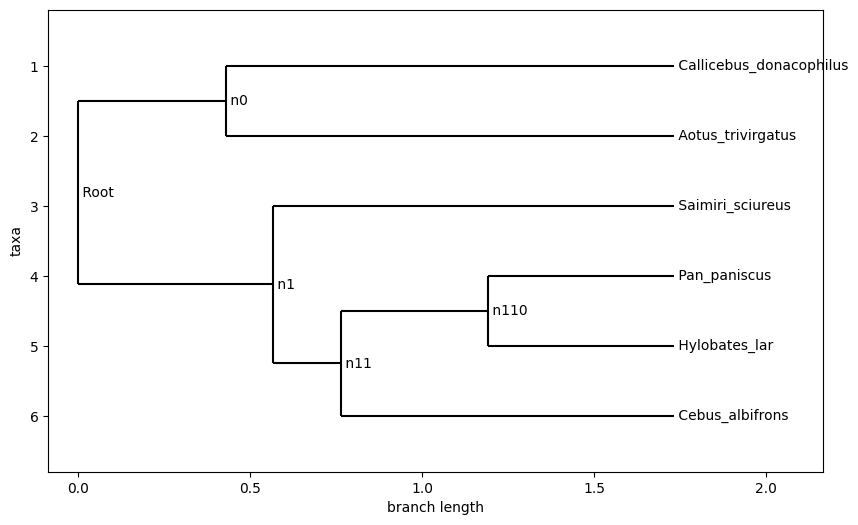

In [16]:
taxa_names = ["Saimiri_sciureus", "Callicebus_donacophilus", "Cebus_albifrons", "Aotus_trivirgatus", "Hylobates_lar", "Pan_paniscus"]

tree_random = Phylogenetic_Tree().generate_random_topology(taxa_names=taxa_names)
tree_random.generate_random_branch_lengths(distribution="uniform", type="ultrametric")
tree_random.draw(figsize=(10,6))

In [ ]:
# # Changes to insert in commit:
